In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd '/content/drive/My Drive/'

/content/drive/My Drive


In [0]:
!mkdir 'mlnet'

mkdir: cannot create directory ‘mlnet’: File exists


In [0]:
%cd '/content/drive/My Drive/mlnet'

/content/drive/My Drive/MLNet-Pytorch


## 0. Downloading Data 

In [0]:
! pip install gdown

In [0]:
!gdown https://drive.google.com/uc?id=1g8j-hTT-51IG1UFwP0xTGhLdgIUCW5e5&export=download
!unzip images.zip
!gdown https://drive.google.com/uc?id=0B2hsWbciDVedNWJZMlRxeW1PY1U&export=download
! unzip maps.zip  

Manually do this step



1. Train Images -> images
2. Test Images -> test_images
3. Val Images -> val_images
4. Train maps -> train
5. Val maps -> val


#### Sometimes there will be error related to the data, it is because your drive is slow. Reload again.




In [0]:
%ls

fixations.zip  images/  images.zip  unzipping_maps.log


In [0]:
import cv2
import numpy as np 
import os 
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torchvision.models as models
import time
import torchvision.transforms as transforms
import time
import datetime
import matplotlib.pyplot as plt

imgs_train_path = 'images/'
maps_train_path = 'train/'

imgs_val_path = 'val_images/'
maps_val_path = 'val/'

In [0]:

def padding(img, shape_r=480, shape_c=640, channels=3):
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)
    else
      img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)

    original_shape = img.shape
    rows_rate = original_shape[0]/shape_r
    cols_rate = original_shape[1]/shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = cv2.resize(img, (shape_c, new_rows))
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded


In [0]:


def preprocess_images(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), shape_r, shape_c, 3))

    for i, path in enumerate(paths):
        original_image = cv2.imread(path)
        padded_image = padding(original_image, shape_r, shape_c, 3)
        ims[i] = padded_image.astype('float')
    
    ims = ims[...,::-1]
    ims /= 255.0
    ims = np.rollaxis(ims, 3, 1)  
    return ims


def preprocess_maps(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), 1, shape_r, shape_c))

    for i, path in enumerate(paths):
        original_map = cv2.imread(path, 0)
        padded_map = padding(original_map, shape_r, shape_c, 1)
        ims[i, 0] = padded_map.astype(np.float32)
        ims[i, 0] /= 255.0
        

    return ims

In [0]:
def generator(b_s, phase_gen='train'):
    if phase_gen == 'train':
        images = [imgs_train_path + f for f in os.listdir(imgs_train_path) if f.endswith('.jpg')]
        maps = [maps_train_path + f for f in os.listdir(maps_train_path) if f.endswith('.png')]
    elif phase_gen == 'val':
        images = [imgs_val_path + f for f in os.listdir(imgs_val_path) if f.endswith('.jpg')]
        maps = [maps_val_path + f for f in os.listdir(maps_val_path) if f.endswith('.png')]
    else:
        raise NotImplementedError

    images.sort()
    maps.sort()
    counter = 0
    
    while True:
        yield preprocess_images(images[counter:counter + b_s], shape_r, shape_c), preprocess_maps(maps[counter:counter + b_s], shape_r_gt, shape_c_gt)
        if counter + b_s >= len(images):
          break
        counter = counter + b_s

In [0]:
!pip3 install torchvision

### Model


In [0]:
import torch
import torch.nn as nn
import torchvision.models as models


class MLNet(nn.Module):
    
    def __init__(self,prior_size):
        super(MLNet, self).__init__()
        features = list(models.vgg16(pretrained = True).features)[:-1]
        features[23].stride = 1
        features[23].kernel_size = 5
        features[23].padding = 2
                
        self.features = nn.ModuleList(features).eval() 
        self.fddropout = nn.Dropout2d(p=0.5)
        self.int_conv = nn.Conv2d(1280,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pre_final_conv = nn.Conv2d(64,1,kernel_size=(1, 1), stride=(1, 1) ,padding=(0, 0))
        self.prior = nn.Parameter(torch.ones((1,1,prior_size[0],prior_size[1]), requires_grad=True))
        self.bilinearup = torch.nn.UpsamplingBilinear2d(scale_factor=10)
        
    def forward(self, x):
        
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {16,23,29}:
                results.append(x)
        
        # concat to get 1280 = 512 + 512 + 256
        x = torch.cat((results[0],results[1],results[2]),1) 
        x = self.fddropout(x)
        x = self.int_conv(x)
        x = self.pre_final_conv(x)
        
        upscaled_prior = self.bilinearup(self.prior)
        # print ("upscaled_prior shape: {}".format(upscaled_prior.shape))

        # dot product with prior
        x = x * upscaled_prior
        x = torch.nn.functional.relu(x,inplace=True)
        return x


### Custom Loss function

## With Prior

In [0]:
# Modified MSE Loss Function
class ModMSELoss(torch.nn.Module):
    def __init__(self,shape_r_gt,shape_c_gt):
        super(ModMSELoss, self).__init__()
        self.shape_r_gt = shape_r_gt
        self.shape_c_gt = shape_c_gt
        
    def forward(self, output , label , prior):
        prior_size = prior.shape
        output_max = torch.max(torch.max(output,2)[0],2)[0].unsqueeze(2).unsqueeze(2).expand(output.shape[0],output.shape[1],self.shape_r_gt,self.shape_c_gt)
        reg = ( 1.0/(prior_size[0]*prior_size[1]) ) * ( 1 - prior)**2
        loss = torch.mean( ((output / output_max) - label)**2 / (1 - label + 0.1) )  +  torch.sum(reg)
        return loss

## Training Model

In [0]:
shape_r = 240
shape_c = 320
shape_r_gt = 30
shape_c_gt = 40
last_freeze_layer = 23

In [0]:
prior_size = ( int(shape_r_gt / 10) , int(shape_c_gt / 10) )
model = MLNet().cuda()
# freezing Layer
for i,param in enumerate(model.parameters()):
  if i < last_freeze_layer:
    param.requires_grad = False
criterion = ModMSELoss(shape_r_gt,shape_c_gt).cuda()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,weight_decay=0.0005,momentum=0.9,nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)

TypeError: ignored

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
loss_history = []
nb_epochs = 10
batch_size = 16

for epoch in range(nb_epochs):
  t1 = time.time()
  image_trained = 0
  for i,gt_map in generator(batch_size):
      optimizer.zero_grad()
      i,gt_map = torch.tensor(i.copy(),dtype=torch.float),torch.tensor(gt_map,dtype=torch.float)
      for idx,x in enumerate(i):
        i[idx] = normalize(x)   
      i,gt_map = i.cuda(),gt_map.cuda()
      image_trained += batch_size
      out = model.forward(i)
      loss = criterion(out,gt_map,model.prior.clone())
      loss.backward()
      optimizer.step()
    
      if image_trained % (batch_size*20) == 0:
        print ("Epochs:{} Images:{} Loss:{}".format(epoch,image_trained,loss.item()) )
  t2 = time.time()
  time_per_epoch = (t2 - t1) / 60.0
  print ('Time taken for epoch-{} : {}m'.format(epoch,time_per_epoch))

Epcohs:0 Images:320 Loss:0.039372172206640244
Epcohs:0 Images:640 Loss:0.021047363057732582
Epcohs:0 Images:960 Loss:0.03162820264697075
Epcohs:0 Images:1280 Loss:0.02543949894607067
Epcohs:0 Images:1600 Loss:0.021714622154831886
Epcohs:0 Images:1920 Loss:0.023631427437067032
Epcohs:0 Images:2240 Loss:0.024959919974207878
Epcohs:0 Images:2560 Loss:0.02245139144361019
Epcohs:0 Images:2880 Loss:0.023388344794511795
Epcohs:0 Images:3200 Loss:0.021192556247115135
Epcohs:0 Images:3520 Loss:0.02214738540351391
Epcohs:0 Images:3840 Loss:0.021557176485657692
Epcohs:0 Images:4160 Loss:0.02854759246110916
Epcohs:0 Images:4480 Loss:0.02403133735060692
Epcohs:0 Images:4800 Loss:0.020184438675642014
Epcohs:0 Images:5120 Loss:0.02723928540945053
Epcohs:0 Images:5440 Loss:0.02498629130423069
Epcohs:0 Images:5760 Loss:0.021401749923825264
Epcohs:0 Images:6080 Loss:0.02535790577530861
Epcohs:0 Images:6400 Loss:0.016310425475239754
Epcohs:0 Images:6720 Loss:0.017156999558210373
Epcohs:0 Images:7040 Loss

In [0]:
## savind model

!mkdir saved_models -p
additional_info = 'my_model'
full_path = 'saved_models/' + str(datetime.datetime.now()) + '_' + additional_info + '.model'
torch.save(model.state_dict(), full_path)

## Model Output 

In [0]:
# give the path where model is stored
PATH = ''   # path of created model
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
num = 15
cnt = 0
for i,gt_map in generator(1,phase_gen='val'):
    fig = plt.figure(figsize=(20, 20))
    org_image = i[0].copy()
    org_image = np.rollaxis(org_image, 0, 3) 
    i = torch.tensor(i.copy(),dtype=torch.float)
    for idx,x in enumerate(i):
        i[idx] = normalize(x)
    i = i.cuda()
    ax1 = plt.subplot(3, 3, 1)
    ax1.set_title('original')
    plt.imshow(org_image)
    # ax1.plot(org_image)
    out = model.forward(i)
    ax1 = plt.subplot(3, 3, 2)
    ax1.set_title('predicted')
    plt.imshow(out[0].squeeze(0).data.cpu().numpy(),cmap='gray')

    ax1 = plt.subplot(3, 3, 3)
    ax1.set_title('gt')
    plt.imshow(gt_map[0][0],cmap='gray')
    
    plt.show()
    fig.savefig('%s.png'%cnt)
    cnt += 1
    if cnt > num:
      break

In [0]:
#### comparing 2 models  ## No need to run This

PATH1 = 'saved_models/2019-11-22 07:24:38.815721_my_model.model'
PATH2 = 'saved_models2/2019-11-21 10_43_21.727494_my_model.model'
model1 = MLNet(prior_size).cuda()
model2 = MLNet(prior_size).cuda()

model1.load_state_dict(torch.load(PATH1))
model2.load_state_dict(torch.load(PATH2))


cnt = 0
for i,gt_map in generator(1,phase_gen='val'):
    fig = plt.figure(figsize=(20, 20))
    org_image = i[0].copy()
    org_image = np.rollaxis(org_image, 0, 3) 
    i = torch.tensor(i.copy(),dtype=torch.float)
    for idx,x in enumerate(i):
        i[idx] = normalize(x)
    i = i.cuda()
    ax1 = plt.subplot(4, 4, 1)
    ax1.set_title('original')
    plt.imshow(org_image)
    
    out1 = model1.forward(i)
    out2 = model2.forward(i)
    
    ax1 = plt.subplot(4, 4, 2)
    ax1.set_title('predicted no prior')
    plt.imshow(out1[0].squeeze(0).data.cpu().numpy(),cmap='gray')
    ax1 = plt.subplot(4, 4, 3)
    ax1.set_title('predicted no Prior')
    plt.imshow(out2[0].squeeze(0).data.cpu().numpy(),cmap='gray')

    ax1 = plt.subplot(4, 4, 4)
    ax1.set_title('gt')
    plt.imshow(gt_map[0][0],cmap='gray')
    
    plt.show()
    fig.savefig('%s.png'%visual_cnt)
    cnt += 1
    if cnt > num:
      break


Original
(240, 320, 3)


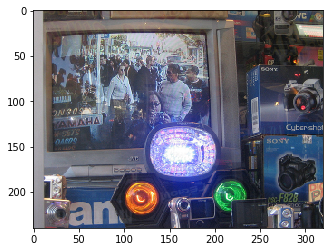

predicted


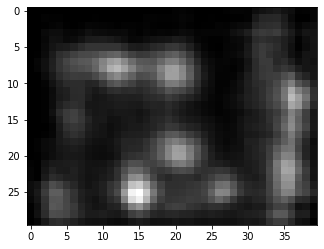

Original


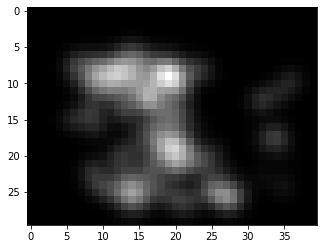

Original
(240, 320, 3)


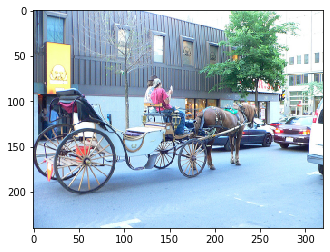

predicted


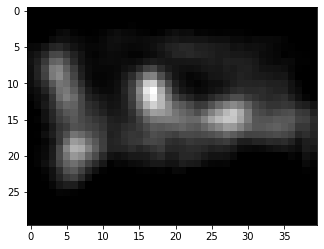

Original


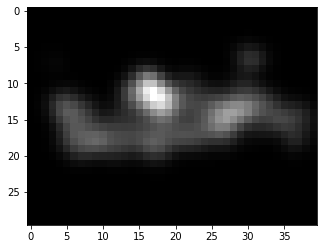

Original
(240, 320, 3)


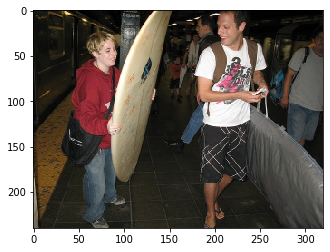

predicted


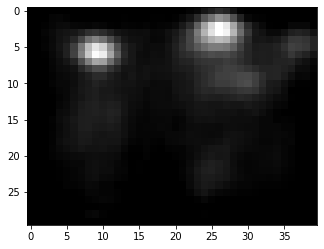

Original


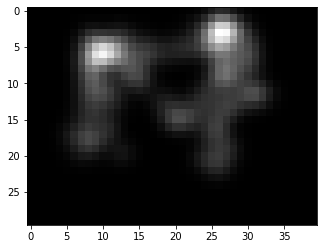

Original
(240, 320, 3)


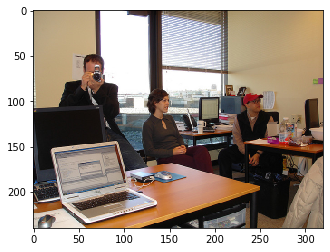

predicted


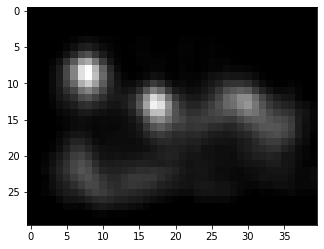

Original


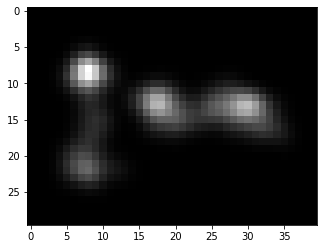

Original
(240, 320, 3)


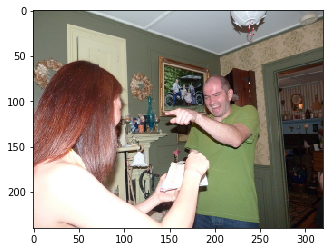

predicted


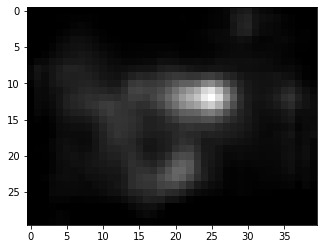

Original


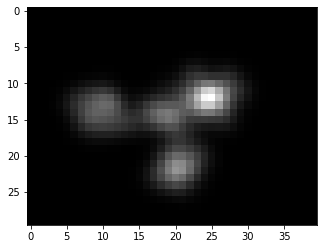

Original
(240, 320, 3)


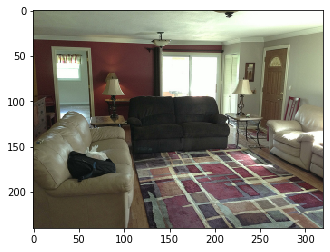

predicted


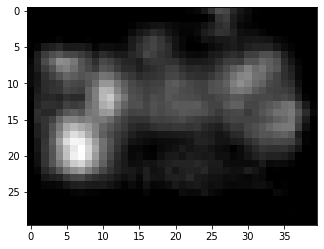

Original


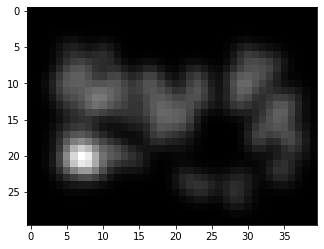

Original
(240, 320, 3)


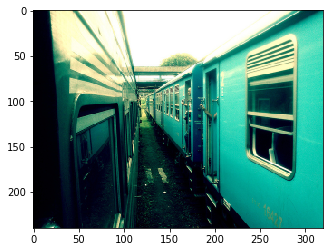

predicted


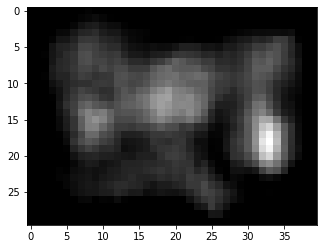

Original


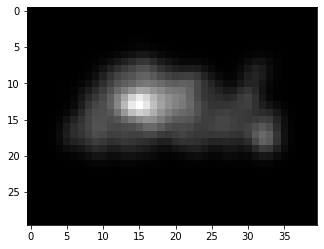

Original
(240, 320, 3)


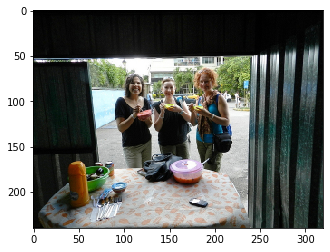

predicted


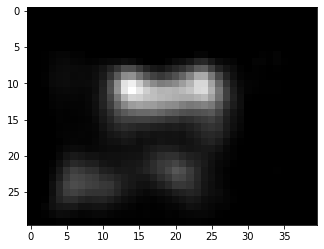

Original


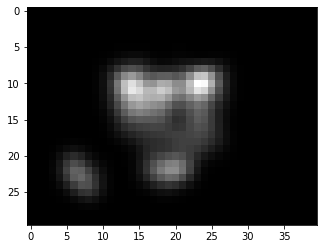

Original
(240, 320, 3)


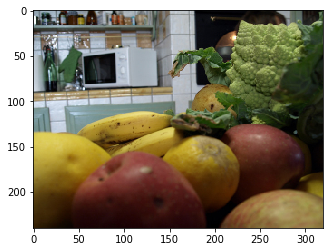

predicted


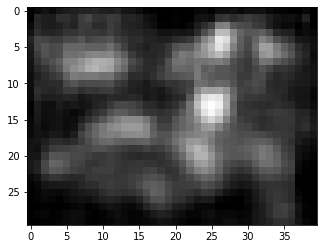

Original


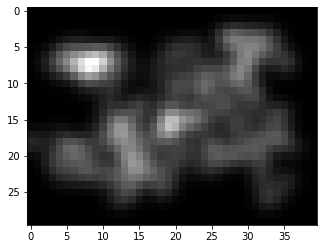

Original
(240, 320, 3)


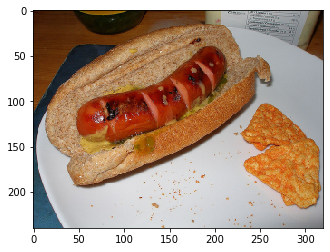

predicted


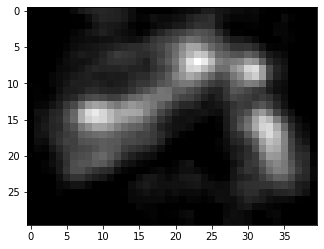

Original


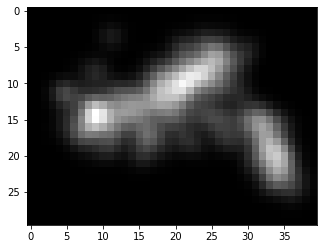

Original
(240, 320, 3)


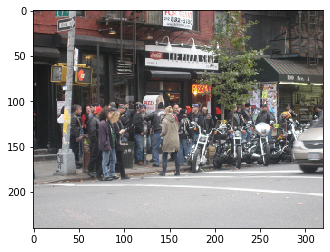

predicted


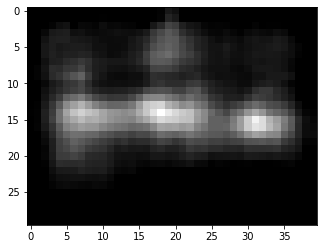

Original


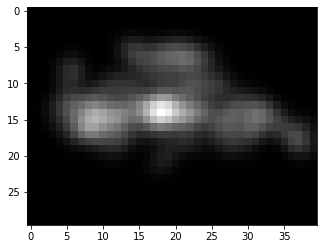

Original
(240, 320, 3)


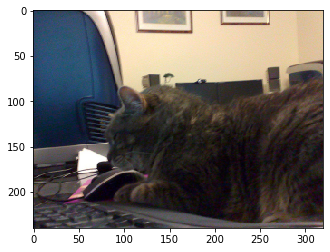

predicted


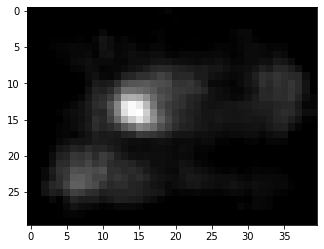

Original


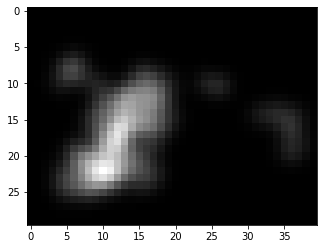

Original
(240, 320, 3)


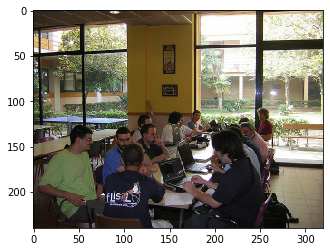

predicted


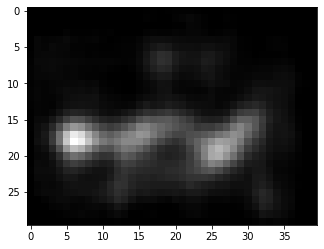

Original


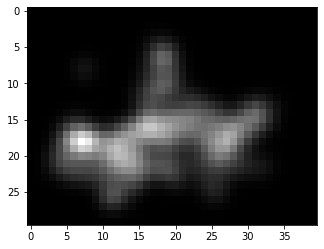

Original
(240, 320, 3)


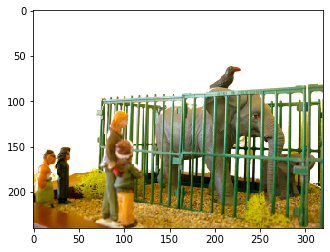

predicted


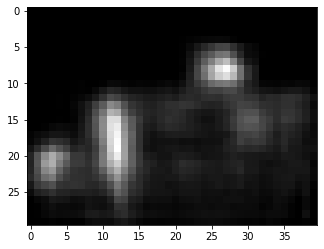

Original


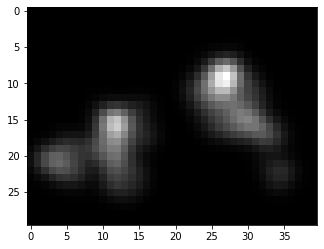

Original
(240, 320, 3)


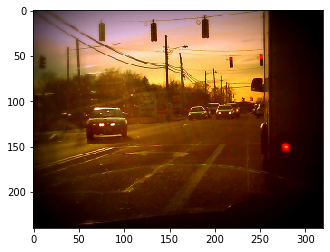

predicted


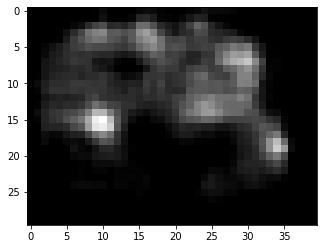

Original


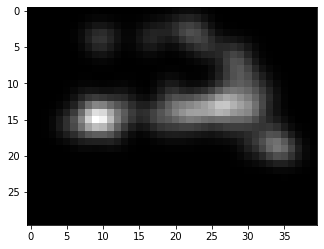

Original
(240, 320, 3)


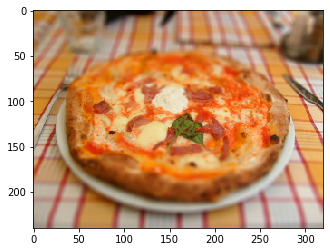

predicted


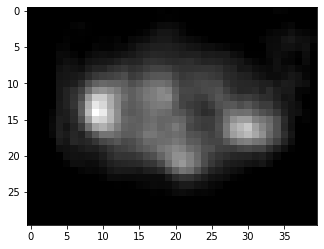

Original


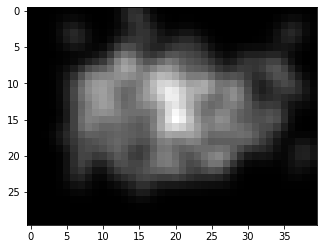

## Run on test set

In [0]:
# creating dir for storing prediction of test images
! mkdir test_maps

In [0]:
test_file = [ f for f in os.listdir('test_images/') if f.endswith('.jpg') ]

for i in test_file:
    img = preprocess_images(['test_images/'+i],shape_r,shape_c)
    img = torch.tensor(img.copy(),dtype=torch.float)
    for idx,x in enumerate(img):
        img[idx] = normalize(x)
    img = img.cuda()
    print(i)
    pred = model.forward(img)
    cv2.imwrite('test_maps/' + i[:-3] + 'png',pred[0].squeeze(0).data.cpu().numpy())

COCO_test2014_000000470887.jpg
COCO_test2014_000000463371.jpg
COCO_test2014_000000463276.jpg
COCO_test2014_000000454149.jpg
COCO_test2014_000000468881.jpg
COCO_test2014_000000458979.jpg
COCO_test2014_000000460819.jpg
COCO_test2014_000000464137.jpg
COCO_test2014_000000473796.jpg
COCO_test2014_000000475233.jpg
COCO_test2014_000000474765.jpg
COCO_test2014_000000463195.jpg
COCO_test2014_000000456267.jpg
COCO_test2014_000000451728.jpg
COCO_test2014_000000453364.jpg
COCO_test2014_000000467001.jpg
COCO_test2014_000000458589.jpg
COCO_test2014_000000477564.jpg
COCO_test2014_000000468138.jpg
COCO_test2014_000000459454.jpg
COCO_test2014_000000452238.jpg
COCO_test2014_000000473308.jpg
COCO_test2014_000000452405.jpg
COCO_test2014_000000468271.jpg
COCO_test2014_000000469077.jpg
COCO_test2014_000000463328.jpg
COCO_test2014_000000471804.jpg
COCO_test2014_000000451325.jpg
COCO_test2014_000000471341.jpg
COCO_test2014_000000474449.jpg
COCO_test2014_000000470179.jpg
COCO_test2014_000000454572.jpg
COCO_tes

# The code below is for the experimental model after removing the prior from the network and changing the loss function

In [0]:
# for experimental model without the prior
import torch
import torch.nn as nn
import torchvision.models as models


class MLNet(nn.Module):
    
    def __init__(self):
        super(MLNet, self).__init__()
        features = list(models.vgg16(pretrained = True).features)[:-1]
        
        features[23].stride = 1
        features[23].kernel_size = 5
        features[23].padding = 2
                
        self.features = nn.ModuleList(features).eval() 
        self.fddropout = nn.Dropout2d(p=0.5)
        self.int_conv = nn.Conv2d(1280,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pre_final_conv = nn.Conv2d(64,1,kernel_size=(1, 1), stride=(1, 1) ,padding=(0, 0))

    def forward(self, x):
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {16,23,29}:
                results.append(x)
        x = torch.cat((results[0],results[1],results[2]),1) 
        x = self.fddropout(x)
        # 64 filters convolution layer
        x = self.int_conv(x)
        # 1*1 convolution layer
        x = self.pre_final_conv(x)
        x = torch.nn.functional.relu(x,inplace=True)
        return x

# Modified MSE Loss Function
class ModMSELoss(torch.nn.Module):
    def __init__(self,shape_r_gt,shape_c_gt):
        super(ModMSELoss, self).__init__()
        self.shape_r_gt = shape_r_gt
        self.shape_c_gt = shape_c_gt
        
    def forward(self, output , label ):
        output_max = torch.max(torch.max(output,2)[0],2)[0].unsqueeze(2).unsqueeze(2).expand(output.shape[0],output.shape[1],self.shape_r_gt,self.shape_c_gt)
        loss = torch.mean( ((output / output_max) - label)**2 / (1 - label + 0.1) )  #+  torch.sum(reg)
        return loss

# Input Images size
shape_r = 240
shape_c = 320
shape_r_gt = 30
shape_c_gt = 40

last_freeze_layer = 23

model = MLNet().cuda()
for i,param in enumerate(model.parameters()):
  if i < last_freeze_layer:
    param.requires_grad = False
   
criterion = ModMSELoss(shape_r_gt,shape_c_gt).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)

In [0]:
import time
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

loss_history = []
nb_epochs = 10
batch_size = 16

for epoch in range(nb_epochs):
  t1 = time.time()
  image_trained = 0
  for i,gt_map in generator(batch_size):
      optimizer.zero_grad()
#       print (i.shape)
      i,gt_map = torch.tensor(i.copy(),dtype=torch.float),torch.tensor(gt_map,dtype=torch.float)
      for idx,x in enumerate(i):
        i[idx] = normalize(x)   
      i,gt_map = i.cuda(),gt_map.cuda()
      image_trained += batch_size
      out = model.forward(i)
      loss = criterion(out,gt_map)
      loss.backward()
      optimizer.step()
    
      if image_trained % (batch_size*20) == 0:
        print ("Epochs:{} Images:{} Loss:{}".format(epoch,image_trained,loss.item()) )
  t2 = time.time()
  time_per_epoch = (t2 - t1) / 60.0
  print ('Time taken for epoch-{} : {}m'.format(epoch,time_per_epoch))

In [0]:
import time
import datetime

# saving model weight
additional_info = 'my_model'
full_path = 'saved_models/' + str(datetime.datetime.now()) + '_' + additional_info + '.model'
torch.save(model.state_dict(), full_path)

In [0]:
PATH = # path of the saved model
model.load_state_dict(torch.load(PATH))

Now test on some random images from the dataset

In [0]:

import matplotlib.pyplot as plt
no_visual = 15
visual_cnt = 0
for i,gt_map in generator(1,phase_gen='val'):
    fig = plt.figure(figsize=(20, 20))
    org_image = i[0].copy()
    org_image = np.rollaxis(org_image, 0, 3) 
    i = torch.tensor(i.copy(),dtype=torch.float)
    for idx,x in enumerate(i):
        i[idx] = normalize(x)
    i = i.cuda()
    ax1 = plt.subplot(3, 3, 1)
    ax1.set_title('original')
    plt.imshow(org_image)
    # ax1.plot(org_image)
    out = model.forward(i)
    
    ax1 = plt.subplot(3, 3, 2)
    ax1.set_title('predicted')
    plt.imshow(out[0].squeeze(0).data.cpu().numpy(),cmap='gray')
    
    ax1 = plt.subplot(3, 3, 4)
    ax1.set_title('gt')
    plt.imshow(gt_map[0][0],cmap='gray')
    
    plt.show()
    visual_cnt += 1
    if visual_cnt > no_visual:
      break

## Below code is to run model on video. You have to run this on your pc to get the results as colab don't support this

In [0]:
full_path = 'saved_models/' + '2019-11-21 10_43_21.727494_my_model' + '.model'
prior_size = (int(shape_r_gt / 10) , int(shape_c_gt / 10))
model = MLNet(prior_size).cuda()
model.load_state_dict(torch.load(full_path))


# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")


def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, img2 = cap.read()
    img = img2
    if ret == True:
    
        img = preprocess_images(img,shape_r,shape_c)
        img = torch.tensor(img.copy(),dtype=torch.float)
        for idx,x in enumerate(img):
            img[idx] = normalize(x)
        img = img.cuda()
        
        pred = model.forward(img)
        #    cv2.imwrite('test_maps/' + i[:-3] + 'png',pred[0].squeeze(0).data.cpu().numpy())
            # Display the resulting frame
        img = pred[0].squeeze(0).data.cpu().numpy()
        img = rescale_frame(img, percent=400)
        img = cv2.resize(img, (img.shape[1]*4, img.shape[0]*4))
        cv2.imshow('Frame', img)
        cv2.imshow('frame2', img2)
            # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
			      break
        
  # Break the loop
    else: 
        break
  
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()